# Cuadratura Gaussiana

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy import integrate
sym.init_printing(use_unicode=True)

In [2]:
x = sym.Symbol('x',real=True)
y = sym.Symbol('y',real=True)

Seguimos con el problema de integrar una función $f(x)$ en cierto intervalo \[a,b\] mediante su cuadratura. Es decir, realizando una suma con pesos de la función en ciertos nodos

$$\begin{align*}
\int_a^b f(x) dx = \sum_{k=0}^{n-1} c_k f(x_k)
\end{align*}
$$

## Gauss-Legendre

La aproximación de Gauss-Legendre consiste en encontrar los $k$ nodos y pesos tal que 
    $$ \begin{align*}
        \int_{-1}^1 f(x) dx &= \sum_{k=0}^{n-1} c_k f(x_k) 
    \end{align*}$$
    Se puede demostrar que para $n$ nodos, estos están dados por los ceros de los *Polinomios de Legendre*, definidos mediante la fórmula de Rodrigues como

$$ \begin{align*}
P_n(x) &= \frac{1}{2^n n!} \frac{d^n}{dx^n}(x^2-1)^n
\end{align*} $$

A partir de esto, se puede crear una función en Python que retorne el $n$-ésimo polinomio de Legendre.

In [3]:
def GetLegendre(n,x,y):
    
    y = (x**2 - 1)**n
    
    poly = sym.diff( y,x,n )/(2**n*np.math.factorial(n))
    
    return poly

Los polinomios de Legendre también satisfacen la ecuación de recursión

$$
\begin{align*}
(n+1)P_{n+1}(x) &= (2n+1)xP_n(x)-nP_{n-1}(x),
\end{align*}
$$

por lo que se puede escribir la función anterior de forma recursiva.

In [4]:
def GetLegendreRecursive(n,x):

    if n==0:
        poly = sym.Number(1)
    elif n==1:
        poly = x
    else:
        poly = ((2*n-1)*x*GetLegendreRecursive(n-1,x)-(n-1)*GetLegendreRecursive(n-2,x))/n
   
    return sym.expand(poly,x)

Veamos un ejemplo de estos polinomios para distintos $n$,

In [5]:
GetLegendreRecursive(0,x)

c:\Users\ASUS\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
c:\Users\ASUS\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
c:\Users\ASUS\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
c:\Users\ASUS\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The MathtextBacken

In [6]:
GetLegendreRecursive(1,x)

In [7]:
GetLegendreRecursive(3,x)

Para encontrar sus ceros, utilizamos el método de Newton-Rhapson teniendo en cuenta que el $n$-ésimo polinomio tendrá $n$ raíces. Antes de eso, encontremos la derivada de Legendre,

In [8]:
def GetDLegendre(n,x):
    Pn = GetLegendreRecursive(n,x)
    return sym.diff(Pn,x,1)

In [9]:
def GetNewton(f,df,xn,itmax=10000,precision=1e-14):
    
    error = 1.
    it = 0
    
    while error >= precision and it < itmax:
        
        try:
            
            xn1 = xn - f(xn)/df(xn)
            
            error = np.abs(f(xn)/df(xn))
            
        except ZeroDivisionError:
            print('Zero Division')
            
        xn = xn1
        it += 1
        
    if it == itmax:
        return False
    else:
        return xn

In [10]:
def GetRoots(f,df,x,tolerancia = 10):
    
    Roots = np.array([])
    
    for i in x:
        
        root = GetNewton(f,df,i)

        if  type(root)!=bool:
            croot = np.round( root, tolerancia )
            
            if croot not in Roots:
                Roots = np.append(Roots, croot)
                
    Roots.sort()
    
    return Roots

In [11]:
def GetAllRootsGLeg(n):

    xn = np.linspace(-1,1,100)
    
    Legendre = []
    DLegendre = []
    
    for i in range(n+1):
        Legendre.append(GetLegendreRecursive(i,x))
        DLegendre.append(GetDLegendre(i,x))
    
    poly = sym.lambdify([x],Legendre[n],'numpy')
    Dpoly = sym.lambdify([x],DLegendre[n],'numpy')
    Roots = GetRoots(poly,Dpoly,xn)

    if len(Roots) != n:
        ValueError('El número de raíces debe ser igual al n del polinomio.')
    
    return Roots

In [12]:
GetAllRootsGLeg(3)

array([-0.77459667,  0.        ,  0.77459667])

Los pesos de Gauss-Legendre están dados a su vez por 
    $$ \begin{align*}
        c_k &= \frac{2}{(1-x_k^2)[P_n'(x_k)]^2}
    \end{align*}$$
    donde $x_k$ es el $k$-ésimo cero del polinomio $n$-ésimo de Legendre, por lo que se puede escribir una función en python que dado un $n$, retorne el arreglo de pesos de Gauss-Legendre. 

In [13]:
def GetWeightsGLeg(n):

    Roots = GetAllRootsGLeg(n)

    

    DLegendre = []
    
    for i in range(n+1):
        DLegendre.append(GetDLegendre(i,x))
    
    Dpoly = sym.lambdify([x],DLegendre[n],'numpy')
    Weights = 2/((1-Roots**2)*Dpoly(Roots)**2)
    
    return Weights

In [14]:
raices = GetAllRootsGLeg(5)

In [15]:
pesos = GetWeightsGLeg(5)

In [16]:
funcion = lambda x: x**4

In [17]:
I = 0
for i in range(5):
    I += pesos[i]*funcion(raices[i])

In [18]:
I

## Gauss-Laguerrre

La aproximación de Gauss-Laguerre consiste en encontrar los $k$ nodos y pesos tal que 
    $$ \begin{align*}
        \int_{0}^\infty e^{-x} f(x) dx &= \sum_{k=0}^{n-1} c_k f(x_k) 
    \end{align*}$$
    Se puede demostrar que para $n$ nodos, estos están dados por los ceros de los *Polinomios de Laguerre*, definidos mediante la fórmula de Rodrigues como

$$ \begin{align*}
L_n(x) &= \frac{e^x}{n!} \frac{d^n}{dx^n}(e^{-x}x^n)
\end{align*} $$

A partir de esto, se puede crear una función en Python que retorne el $n$-ésimo polinomio de Laguerre. Los polinomios de Laguerre también satisfacen la ecuación de recursión

$$
\begin{align*}
L_{k+1} &= \frac{(2k+1-x)L_k(x)-kL_{k-1}(x)}{k+1}
\end{align*}
$$

por lo que se puede escribir la función anterior de forma recursiva teniendo en cuenta que $L_0(x)=1, L_1(x)=1-x$.

**Ejercicio 3.1**
1. Escriba una función `GetLaguerre(n,x)` que retorne el $n$-ésimo polinomio de Laguerre de forma recursiva.
2. Escriba una función `GetAllRootsGLag(n)` que encuentre todas las raíces del $n$-ésimo polinomio de Laguerre. Para esto, utilize el hecho de que las raíces están acotadas en el intervalo $(0,n+(n-1)\sqrt{n})$
3. Escriba una función `GetWeightsGLag(n)` que encuentre los $n$-pesos del $n$-ésimo polinomio de Laguerre. Tenga en cuenta que estos pesos están dados por 
$$
\begin{align*}
c_k &= \frac{x_k}{(n+1)^2 [L_{n+1}(x_k)]^2}
\end{align*}
$$


In [19]:
def GetLaguerre(n,x):

    if n==0:
        poly = sym.Number(1)
    elif n==1:
        poly = -x + 1
    else:
        poly = ((2*n -1 -x)*GetLaguerre(n-1,x)-(n-1)*GetLaguerre(n-2,x))/n
   
    return sym.expand(poly,x)

def GetDLaguerre(n,x):
    Pn = GetLaguerre(n,x)
    return sym.diff(Pn,x,1)

def GetAllRootsGLag(n):
    
    xn = np.linspace(0,n+((n-1)*n**(1/2)),100)
    
    Laguerre = []
    DLaguerre = []
    
    for i in range(n+1):
        Laguerre.append(GetLaguerre(i,x))
        DLaguerre.append(GetDLaguerre(i,x))
    
    poly = sym.lambdify([x],Laguerre[n],'numpy')
    Dpoly = sym.lambdify([x],DLaguerre[n],'numpy')
    Roots = GetRoots(poly,Dpoly,xn)

    if len(Roots) != n:
        ValueError('El número de raíces debe ser igual al n del polinomio.')
    
    return Roots

def GetWeightsGLag(n):

    Roots = GetAllRootsGLag(n)

    Laguerre = []
    
    for i in range(n+2):
        Laguerre.append(GetLaguerre(i,x))
    
    poly = sym.lambdify([x],Laguerre[n+1],'numpy')
    Weights = Roots/(((n+1)**2)*(poly(Roots)**2))
    
    return Weights

n = 6
Roots, Weights = np.polynomial.laguerre.laggauss(n)
raices = GetAllRootsGLag(n)
pesos = GetWeightsGLag(n)
print(Roots)
print(raices)
print(Weights)
print(pesos)

[ 0.2228466   1.1889321   2.99273633  5.77514357  9.83746742 15.98287398]
[ 0.2228466   1.1889321   2.99273633  5.77514357  9.83746742 15.98287398]
[4.58964674e-01 4.17000831e-01 1.13373382e-01 1.03991975e-02
 2.61017203e-04 8.98547906e-07]
[4.58964673e-01 4.17000831e-01 1.13373382e-01 1.03991975e-02
 2.61017203e-04 8.98547906e-07]


## Gauss-Hermite

La aproximación de Gauss-Hermite consiste en encontrar los $k$ nodos y pesos tal que 
    $$ \begin{align*}
        \int_{-\infty}^\infty e^{-x^2} f(x) dx &= \sum_{k=0}^{n-1} c_k f(x_k) 
    \end{align*}$$
    Se puede demostrar que para $n$ nodos, estos están dados por los ceros de los *Polinomios de Hermite*, definidos mediante la fórmula de Rodrigues como

$$ \begin{align*}
H_n(x) &= (-1)^n e^{x^2} \frac{d^n}{dx^n}e^{-x^2}
\end{align*} $$

A partir de esto, se puede crear una función en Python que retorne el $n$-ésimo polinomio de Hermite. Los polinomios de Hermite también satisfacen la ecuación de recursión

$$
\begin{align*}
H_{n+1}(x) = 2xH_n(x)-2nH_{n-1}(x)
\end{align*}
$$

por lo que se puede escribir la función anterior de forma recursiva teniendo en cuenta que $H_0(x)=1, H_1(x)=2x$.

**Ejercicio 3.2**
1. Escriba una función `GetHermite(n,x)` que retorne el $n$-ésimo polinomio de Hermite de forma recursiva.
2. Escriba una función `GetAllRootsGHer(n)` que encuentre todas las raíces del $n$-ésimo polinomio de Hermite. Para esto, utilize el hecho de que las raíces están acotadas en el intervalo $(-\sqrt{4n+1},\sqrt{4n+1})$
3. Escriba una función `GetWeightsGHer(n)` que encuentre los $n$-pesos del $n$-ésimo polinomio de Hermite. Tenga en cuenta que estos pesos están dados por 
$$
\begin{align*}
c_k &= \frac{2^{n-1}n! \sqrt{\pi}}{n^2[H_{n-1}(x_k)]^2}
\end{align*}
$$


In [20]:
def GetHermite(n,x):

    if n==0:
        poly = sym.Number(1)
    elif n==1:
        poly = 2*x
    else:
        poly = (2*x)*GetHermite(n-1,x)-(2*(n-1))*GetHermite(n-2,x)

    return sym.expand(poly,x)

def GetDHermite(n,x):
    Pn = GetHermite(n,x)
    return sym.diff(Pn,x,1)

def GetAllRootsGHer(n):
    
    xn = np.linspace((-1)*((4*n)**(1/2)),(4*n)**(1/2),100)
    
    Hermite = []
    DHermite = []
    
    for i in range(n+1):
        Hermite.append(GetHermite(i,x))
        DHermite.append(GetDHermite(i,x))
    
    poly = sym.lambdify([x],Hermite[n],'numpy')
    Dpoly = sym.lambdify([x],DHermite[n],'numpy')
    Roots = GetRoots(poly,Dpoly,xn)

    if len(Roots) != n:
        ValueError('El número de raíces debe ser igual al n del polinomio.')
    
    return Roots

def GetWeightsGHer(n):

    Roots = GetAllRootsGHer(n)

    Hermite = []
    
    for i in range(n+1):
        Hermite.append(GetHermite(i,x))
    
    poly = sym.lambdify([x],Hermite[n-1],'numpy')
    Weights = ((2**(n-1))*(np.math.factorial(n))*(np.pi**(1/2)))/((n**2)*((poly(Roots)**2)))
    
    return Weights

n = 6
Roots, Weights = np.polynomial.hermite.hermgauss(n)
raices = GetAllRootsGHer(n)
pesos = GetWeightsGHer(n)
print(Roots)
print(raices)
print(Weights)
print(pesos)

[-2.35060497 -1.33584907 -0.43607741  0.43607741  1.33584907  2.35060497]
[-2.35060497 -1.33584907 -0.43607741  0.43607741  1.33584907  2.35060497]
[0.00453001 0.15706732 0.7246296  0.7246296  0.15706732 0.00453001]
[0.00453001 0.15706732 0.7246296  0.7246296  0.15706732 0.00453001]


### Utilizando la cuadratura **Gauss-Laguerre**, resuelva:

En 1852, el físico escocés James Clerk Maxwell describió la distribución de velocidades de moléculas de un gas como 

$$
\begin{align*}
    P(v) &= 4\pi \left( \frac{M}{2\pi R T} \right)^{3/2} v^2 \exp \left( - \frac{Mv^2}{2RT} \right)
\end{align*}
$$


1. Demuestre que $\int_0^\infty P(v) dv =1$, es decir, que es una distribución de probabilidad.
2. Grafique $P(v)$ para distintas temperaturas. ¿Qué puede decir de la velocidad más probable (con mayor $P(v)$) a medida que aumenta la temperatura?
3. Para 10 distintas temperaturas, encuentre la *velocidad promedio*
    
$$
\begin{align*}
v_{avg} &= \int_0^\infty vP(v) dv
    \end{align*}
$$

Grafique (en escala logarítmica) $v_{avg}$ y $T$ y verifique que se cumple

$$
\begin{align*}
    v_{avg} &= \sqrt{\frac{8RT}{\pi M}}
\end{align*}
$$
4. Para 10 distintas temperaturas, encuentre la \textit{velocidad media cuadrática }
$$
\begin{align*}
        v_{rms} &= \sqrt{\int_{0}^\infty v^2 P(v) dv} 
    \end{align*}
$$

Grafique (en escala logarítmica) $v_{rms}$ y $T$ y verifique que se cumple

$$
\begin{align*}
        v_{rms} &= \sqrt{\frac{3RT}{M}}
    \end{align*}
$$
5. Usando lo anterior, demuestre que la energía interna de un gas está dada por $E_{int}=\frac{3}{2}nRT$

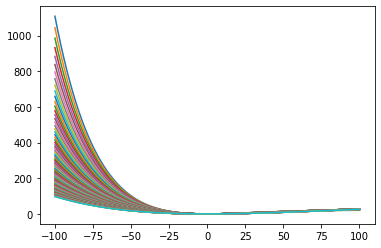

In [21]:
T=np.linspace(100,300,100)
v=np.linspace(-100,100,1000)

def p_v_distintas_temperaturas(T,v):
    return (1/T)*(3/2) * (v**2) * np.exp(-v*2/T)

for i in T:
    eje_y=p_v_distintas_temperaturas(i,v)
    plt.plot(v,eje_y)



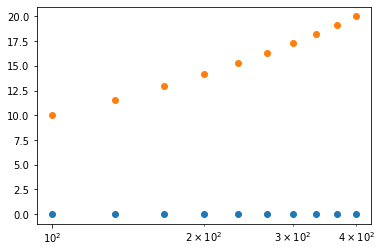

In [22]:
T_10=np.linspace(100,400,10)

def p_v3_prom(T,v):
    return (v**3)/T  

points, weights =np.polynomial.laguerre.laggauss(10)

eje_Y_2=np.zeros(10)

for i in range(len(T_10)):
    integral=np.sum(T_10[i]*(1/(T_10[i]))**(3/2)*weights*p_v3_prom(T_10[i],points))
    eje_Y_2[i]=integral

def funcion_prueba(T):
    return np.sqrt(T)

eje_y_prueba=np.zeros(10)

for i in range(len(T_10)):
    k=funcion_prueba(T_10[i])
    eje_y_prueba[i]=k

plt.scatter(T_10,-eje_Y_2)
#plt.yscale("log")
plt.xscale("log")
plt.scatter(T_10,eje_y_prueba)

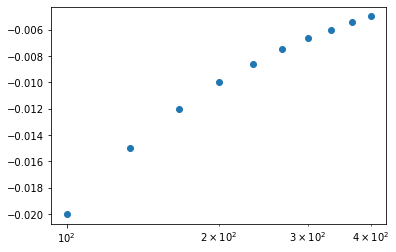

In [23]:
def p_v_media_cuadratica (T,v): 
    res = np.sqrt((v**4)/T)
    return res  

eje_Y_3=np.zeros(10)

for i in range(len(T_10)):
    integral=np.sum(T_10[i]*(1/(T_10[i]))**(3/2)*weights*p_v_media_cuadratica(T_10[i],points))
    eje_Y_3[i]=integral

plt.scatter(T_10,-eje_Y_3)
plt.xscale("log")

Para la gráfica de la segunda parte del punto 4, se puede usar la misma del punto 3 debido a que estas tienen el mismo comportamiento.

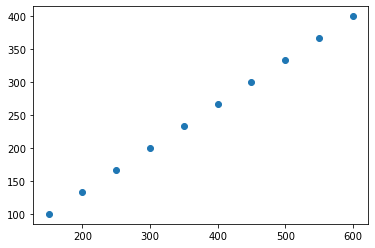

In [24]:
Energia = []
Temperatura = []

for i in T_10: 
    v_avg= p_v3_prom(i,v)
    v_rms= p_v_media_cuadratica(i,v)

    E_int=(3/2)*i
    Energia.append(E_int)
    Temperatura.append(i)

plt.scatter(Energia,Temperatura)